In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import glob
import os
from matplotlib import cm
import dask
import pickle
import matplotlib as mpl
from matplotlib.markers import MarkerStyle


In [2]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
final_models = list(pd.read_csv('../../scores/results.csv').set_index('Model').index)
final_models = [model for model in final_models if model not in ['ERA5' , 'NOAA']]

winners = ['MIROC-ESM-CHEM','BNU-ESM','CNRM-CM5','GFDL-ESM2M','bcc-csm1-1','ACCESS1-0']
winners = [i for i in winners if i in final_models]

In [4]:
def get_mean(dic):
    return (dic['JJA']+dic['SON']+dic['MAM']+dic['DJF'])/4

In [5]:
rcp85_high = pickle.load( open("../HIGH/rcp85_dic.p", "rb"))
hist_high =  pickle.load( open("../HIGH/hist_dic.p", "rb"))

rcp85_jet = pickle.load( open("../JET/rcp85_dic.p", "rb"))
hist_jet =  pickle.load( open("../JET/historical_dic.p", "rb"))

In [6]:
pr_dic = pickle.load(open("../pr/monthly_pr_dic.p", "rb"))

In [7]:
tas_dic = pickle.load(open("../tas/monthly_tas_dic.p", "rb"))

In [8]:
vmin = []
vmax = []
for model in winners:
    High_final = (get_mean(rcp85_high[model]) - get_mean(hist_high[model]))
    vmin.append(np.min(High_final.values))
    vmax.append(np.max(High_final.values))

    
vmin_high = np.min(vmin)
vmax_high = np.max(vmax)

norm_high = MidpointNormalize(vmin=vmin_high, vmax=vmax_high, midpoint=0)

In [9]:
vmin = []
vmax = []
for model in final_models:
    Jet = (rcp85_jet[model].mean(dim='time') - hist_jet[model].mean(dim='time'))
    vmin.append(np.min(Jet.values))
    vmax.append(np.max(Jet.values))
    
vmin_jet = np.min(vmin)
vmax_jet = np.max(vmax)

norm_jet = MidpointNormalize(vmin=vmin_jet, vmax=vmax_jet, midpoint=0)

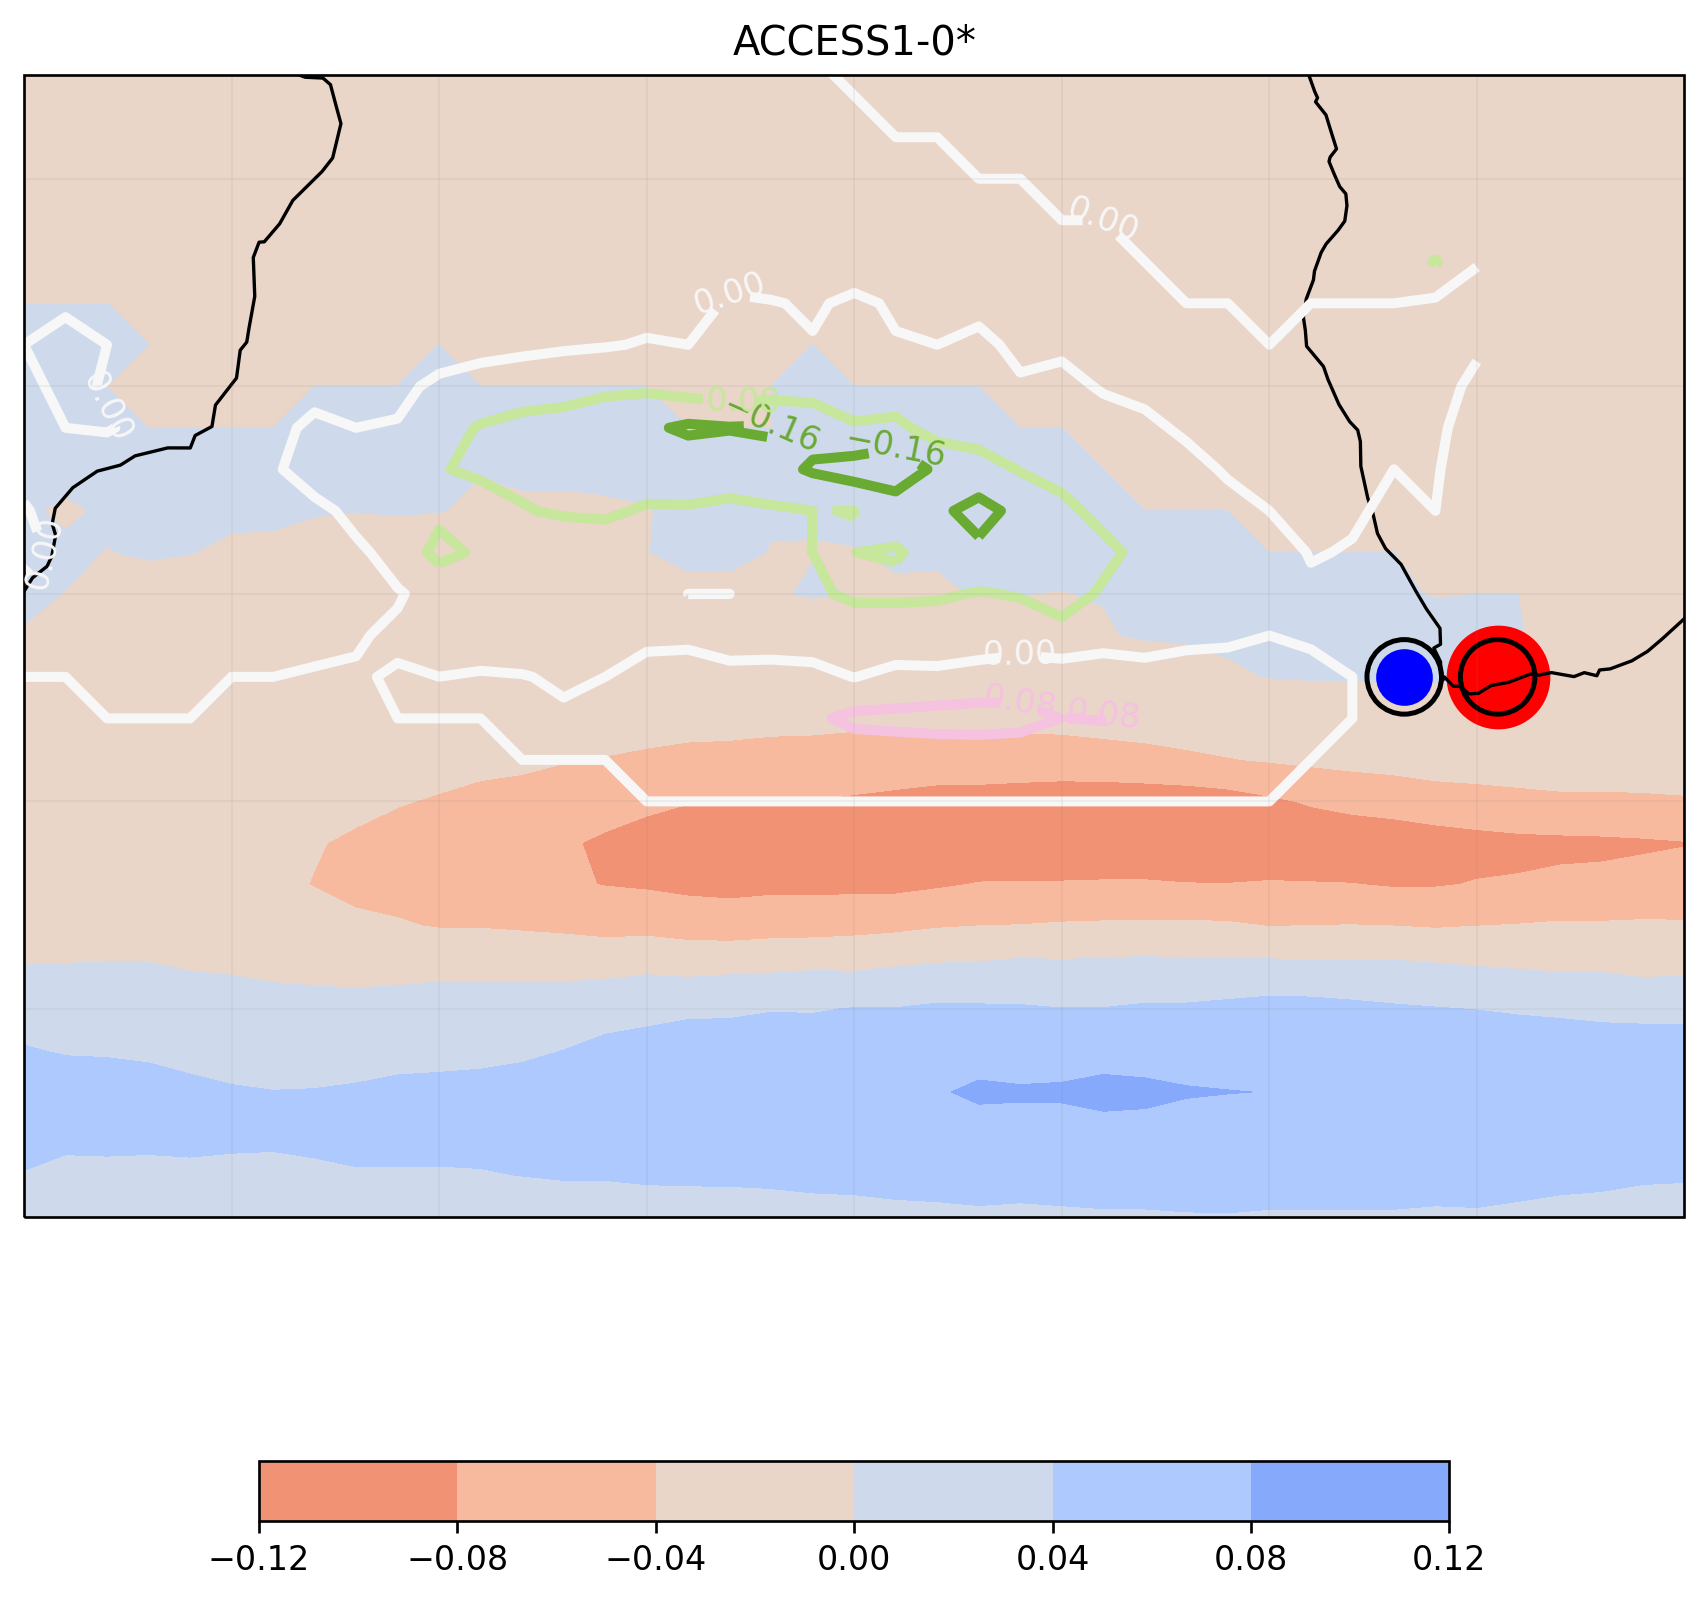

In [23]:
model = 'ACCESS1-0'
Jet_final = (rcp85_jet[model].mean(dim='time') - hist_jet[model].mean(dim='time'))
High_final = (get_mean(rcp85_high[model]) - get_mean(hist_high[model]))
fig = plt.figure(figsize=(16,9), dpi = 240)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cmap = 'coolwarm_r'
j = ax.contourf(Jet_final.lon,Jet_final.lat,Jet_final,  cmap = cmap, norm = norm_jet, vmin = vmin_jet, vmax = vmax_jet, transform = ccrs.PlateCarree(),levels = 5, alpha =1)
cmap = 'PiYG_r' 
c = ax.contour(High_final.lon,High_final.lat,High_final,cmap=cmap, norm = norm_high, vmin = vmin_high, vmax = vmax_high, transform = ccrs.PlateCarree(),levels = 4, linewidths = 3, alpha = 1)
ax.clabel(c, c.levels, inline=True, fontsize=10)
if model in winners:
    plt.title(str(model)+'*')
else:
    plt.title(str(model))
plt.colorbar(j, shrink = 0.4, orientation = 'horizontal')
ax.gridlines(linewidth=0.5, color='gray', alpha=0.1)
ax.set_extent([-50, 30, -60, -5], ccrs.PlateCarree())
ax.scatter(y = -34,x = 16.5 , s = (500 + (1.6e8* (pr_dic[model].sel(time = slice('2045','2100')).mean(dim = 'time').values) - (pr_dic[model].sel(time = slice('1950','2005')).mean(dim = 'time').values))), color = 'blue', alpha = 1)
ax.scatter(y = -34,x = 16.5 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.scatter(y = -34,x = 21, s = (500 + (1.8e2 *(tas_dic[model].sel(time = slice('2045','2100')).mean(dim = 'time').values) - (tas_dic[model].sel(time = slice('1950','2005')).mean(dim = 'time').values))), color = 'red', alpha = 1)
ax.scatter(y = -34,x = 21 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))

In [21]:
for model in final_models:
    Jet_final = (rcp85_jet[model].mean(dim='time') - hist_jet[model].mean(dim='time'))
    High_final = (get_mean(rcp85_high[model]) - get_mean(hist_high[model]))
    fig = plt.figure(figsize=(16,9), dpi = 240)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cmap = 'coolwarm_r'
    j = ax.contourf(Jet_final.lon,Jet_final.lat,Jet_final,  cmap = cmap, norm = norm_jet, vmin = vmin_jet, vmax = vmax_jet, transform = ccrs.PlateCarree(),levels = 5, alpha =0.6)
    cmap = 'PiYG_r' 
    c = ax.contour(High_final.lon,High_final.lat,High_final,cmap=cmap, norm = norm_high, vmin = vmin_high, vmax = vmax_high, transform = ccrs.PlateCarree(),levels = 4, linewidths = 3, alpha = 0.8)
    ax.clabel(c, c.levels, inline=True, fontsize=10)
    if model in winners:
        plt.title(str(model)+'*')
    else:
        plt.title(str(model))
    plt.colorbar(j, shrink = 0.4, orientation = 'horizontal')
    ax.gridlines(linewidth=0.5, color='gray', alpha=0.1)
    ax.set_extent([-50, 30, -60, -5], ccrs.PlateCarree())
    ax.scatter(y = -34,x = 16.5 , s = (500 + (1.3e8* (pr_dic[model].sel(time = slice('2045','2100')).mean(dim = 'time').values) - (pr_dic[model].sel(time = slice('1950','2005')).mean(dim = 'time').values))), color = 'blue', alpha = 1)
    ax.scatter(y = -34,x = 16.5 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
    ax.scatter(y = -34,x = 21, s = (500 + (1.7e2 *(tas_dic[model].sel(time = slice('2045','2100')).mean(dim = 'time').values) - (tas_dic[model].sel(time = slice('1950','2005')).mean(dim = 'time').values))), color = 'red', alpha = 1)
    ax.scatter(y = -34,x = 21 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
    plt.savefig('Plots/'+str(model)+'_combo.png', dpi = 240)
    plt.savefig('Plots/'+str(model)+'_combo.pdf')
    plt.close()

In [12]:
###   JET

rcp85 = pickle.load( open("../JET/rcp85_dic.p", "rb"))
hist =  pickle.load( open("../JET/historical_dic.p", "rb"))

full = 0
for model in final_models:
    full = full + (rcp85[model].mean(dim='time') - hist[model].mean(dim='time'))
    
Jet_full = full / len(final_models)

win = 0
for model in winners:
    win = win + (rcp85[model].mean(dim='time') - hist[model].mean(dim='time'))
    
Jet_final = win / len(winners)

In [11]:
###   HIGH

rcp85 = pickle.load( open("../HIGH/rcp85_dic.p", "rb"))
hist =  pickle.load( open("../HIGH/hist_dic.p", "rb"))

full = 0
for model in final_models:
    full = full + (get_mean(rcp85[model]) - get_mean(hist[model]))
    
High_full = full / len(final_models)

win = 0
for model in winners:
    win = win + (get_mean(rcp85[model]) - get_mean(hist[model]))
    
High_final = win / len(winners)

In [59]:
for model in final_models:
    print('{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/'+str(model)+'_combo.pdf}}')

{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/MIROC-ESM-CHEM_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/BNU-ESM_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/CNRM-CM5_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/IPSL-CM5A-MR_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/IPSL-CM5A-LR_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/GFDL-ESM2M_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/GFDL-ESM2G_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Combo_plot/Plots/GFDL-CM3_combo.pdf}}
{\includegraphics[height=2cm,trim={8cm 7.8cm 8cm 1cm},clip]{../projections/Comb

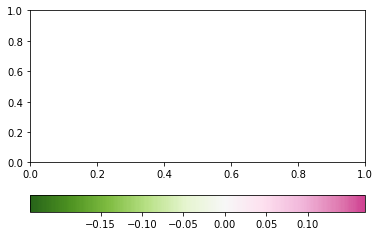

In [22]:
sm = plt.cm.ScalarMappable(norm=norm_high, cmap = c.cmap)
sm.set_array([])
plt.colorbar(sm, ticks=c.levels, orientation = 'horizontal')
plt.savefig('Plots/High_cbar_combo.pdf')

In [46]:
for model in final_models:
    print(model,(tas_dic[model].sel(time = slice('2045','2100')).mean(dim = 'time').values) - (tas_dic[model].sel(time = slice('1950','2005')).mean(dim = 'time').values))

MIROC-ESM-CHEM 2.8065767
BNU-ESM 2.9467099
CNRM-CM5 2.2128043
IPSL-CM5A-MR 3.3721871
IPSL-CM5A-LR 4.4681516
GFDL-ESM2M 1.8618426
GFDL-ESM2G 1.8865836
GFDL-CM3 3.2686281
bcc-csm1-1-m 1.7065618
bcc-csm1-1 2.0200853
ACCESS1-3 2.177832
ACCESS1-0 2.3574982
MRI-ESM1 1.9630712
MRI-CGCM3 1.7965097
MIROC5 1.8897288


In [74]:
fig = plt.figure(figsize=(16,9), dpi = 240)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(y = -34,x = 16.5 , s = (500 + (1.6e8* (-2e-06))), color = 'blue', alpha = 1)
ax.scatter(y = -34,x = 16.5 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [6.9,-34.2] , text = '-2e-6 kg.m.s-1')

ax.scatter(y = -34,x = 21, s = (500 + (1.8e2 *(3))), color = 'red', alpha = 1)
ax.scatter(y = -34,x = 21 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [23,-34.2] , text = '+3 K')

ax.scatter(y = -30,x = 16.5 , s = (500 + (-1.6e8* 1e-06)), color = 'blue', alpha = 1)
ax.scatter(y = -30,x = 16.5 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [6.9,-30.2] , text = '-1e-6 kg.m.s-1')

ax.scatter(y = -30,x = 21, s = (500 + (1.8e2 *(1))), color = 'red', alpha = 1)
ax.scatter(y = -30,x = 21 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [23,-30.2] , text = '+1 K')

ax.set_extent([-50, 30, -60, -5], ccrs.PlateCarree())

plt.savefig('Plots/keys.pdf')
plt.close()